# 인물을 대상으로

In [18]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from keras.models import load_model

from matplotlib import pyplot as plt
import tensorflow as tf

In [19]:
img_path = "data/Celeb/Korean/김유정.jpg"
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(682, 600, 3)


## 사전에 학습된 가중치 불러오기

In [21]:
# define model and download & load pretrained weight
model_dir = './model/model.h5'
model = load_model(model_dir)

print('model loaded successfully!')

model loaded successfully!


In [22]:
test_img = cv2.resize(img_orig, dsize=(512, 512), interpolation=cv2.INTER_AREA)

In [23]:
test_img.shape

(512, 512, 3)

In [24]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
seg_map = model.predict(test_img.reshape(1,512,512,3))[0,:,:,:]
seg_map = np.array(seg_map)
# Convert pixel values from float to integer
seg_map = np.where(seg_map > 0.9, 1, 0)
seg_map = seg_map.astype('uint8')
kernel = np.ones((15,15),np.uint8)
seg_map = cv2.dilate(seg_map,kernel,iterations = 1)
seg_map = np.array(seg_map)
seg_map = np.expand_dims(seg_map, axis=-1)
print (img_orig.shape, seg_map.max())

(682, 600, 3) 1


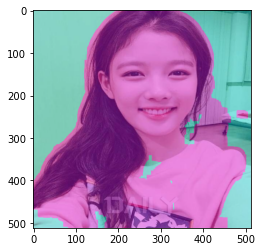

In [25]:
# 사진 중에서 사람의 영역만 검출합니다.
img_show = test_img.copy()
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_COOL)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 세그멘테이션 결과를 원래 크기로 복원하기

원본 이미지의 크기: (600, 682)
변형 마스크의 크기: (512, 512, 1)


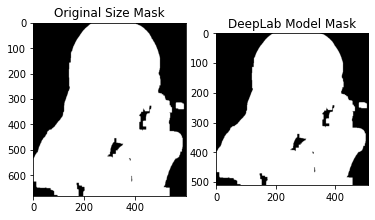

In [26]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'원본 이미지의 크기: {img_orig.shape[:2][::-1]}\n변형 마스크의 크기: {img_mask.shape}')
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 배경 흐리게 하기

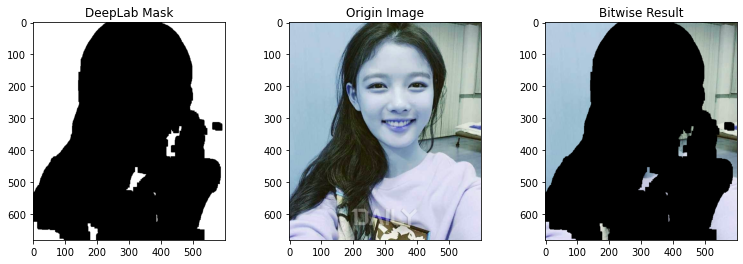

In [27]:
#세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4)) 

ax = plt.subplot(1,3,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,3,2)
plt.imshow(img_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

ax = plt.subplot(1,3,3)
plt.imshow(img_bg, cmap=plt.cm.binary_r)
ax.set_title('Bitwise Result')

plt.show()

Text(0.5, 1.0, 'Blur Processing')

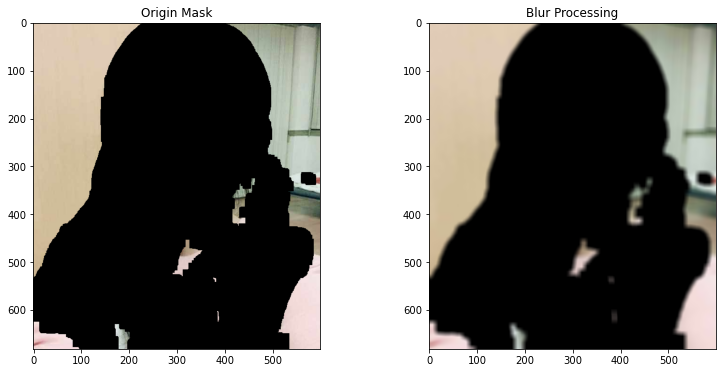

In [28]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.
img_bg_blur = cv2.blur(img_bg, (12,12))

fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

## 흐린 배경과 원본 영상 합성

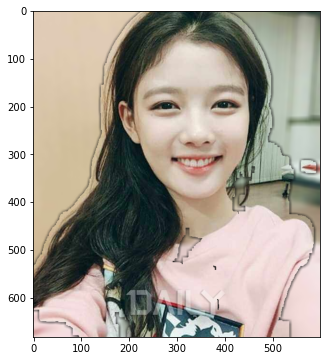

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig = plt.figure(figsize=(16, 6)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 가우시안 Blur 사용하기

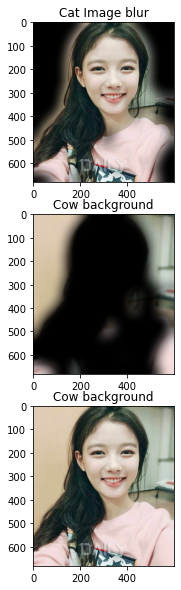

In [30]:
cow_mask = seg_map * (255/seg_map.max()) 
cow_mask = cow_mask.astype(np.uint8)

# 원본 사진과 마스크의 크기를 맞춰준다.
cow_mask_up = cv2.resize(cow_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
# 채널을 원본 사진과 맞게 3 channel로 바꾼다.
cow_mask_3C = np.repeat(np.expand_dims(cow_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
cow_orig_blur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
cow_Gmask = (cv2.GaussianBlur(cow_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
cow_image_blur = cow_Gmask*img_orig.astype(np.float32)
# 1-마스크를 해주는 이유는 Blur 처리한 원본에서 배경만 뽑아내기 위해서이다.
cow_bg_mask = (1-cow_Gmask)*cow_orig_blur.astype(np.float32)
out = (cow_image_blur+cow_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(cow_image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Cat Image blur')

ax = plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(cow_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Cow background')

ax = plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('Cow background')

plt.show()


## 기존 결과의 문제점과 해결방안

In [31]:
problem_ = cv2.imread(os.path.join(img_path, "Problem list.png")) 

plt.figure(figsize=(30, 15))
plt.imshow(cv2.cvtColor(problem_,cv2.COLOR_BGR2RGB))

error: OpenCV(4.4.0) /tmp/pip-req-build-2mquh264/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 2160x1080 with 0 Axes>

### 1번 Blur 경계선 문제 해결 방안

**해결방안 제시**
- Mask 이미지가 0과 1로 극단적으로 나눠져 있기 때문에 경계선이 생기는 문제가 발생합니다. 그래서 마스크의 물체 테두리 부분에서 0과 1(혹은 0과 255)과 같이 step function 모양처럼 변하는 것이 아닌 부드러운 곡선의 형태로 변하면 좋겠다는 생각을 했습니다. 그래서 그냥 Blur 함수가 아닌 부드러운 곡선의 형태를 띄고 있는 Gaussian Blur를 사용했습니다. 

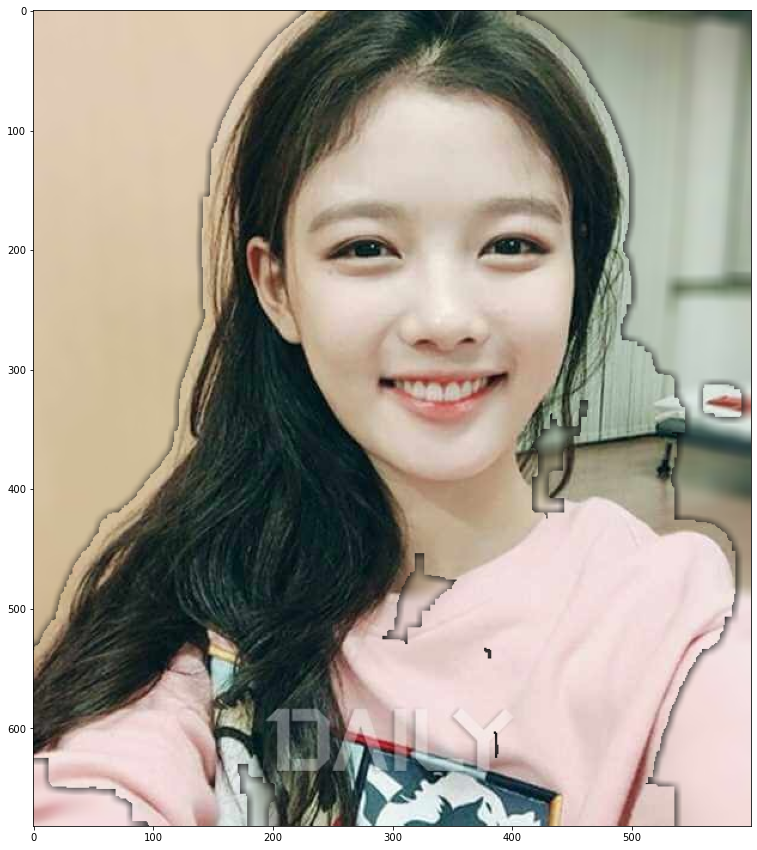

In [34]:
# 기존 이미지
fig = plt.figure(figsize=(30, 15))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

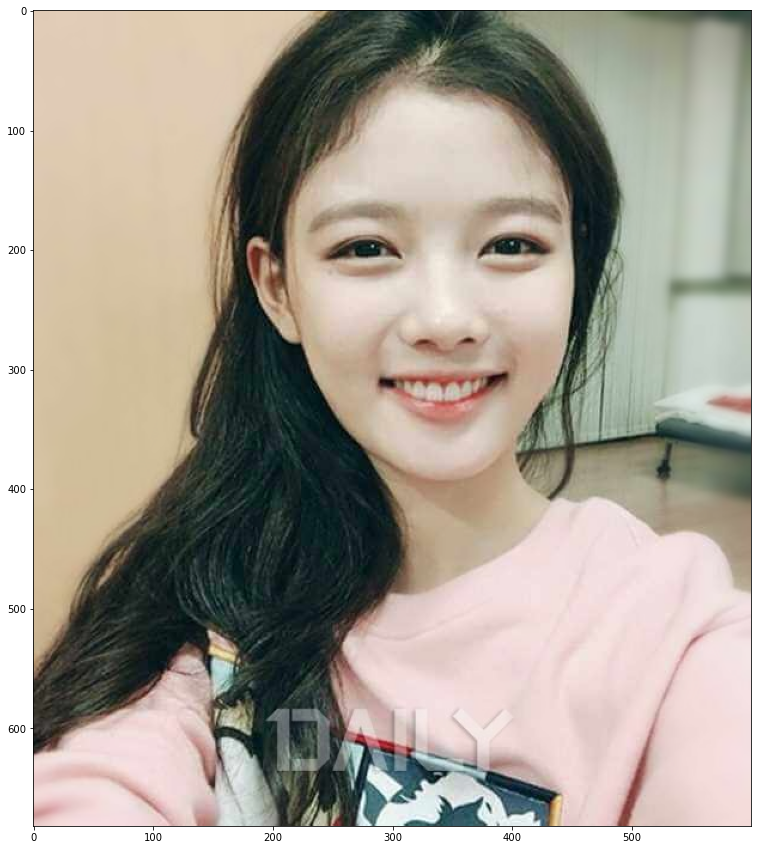

In [33]:
#Gaussian Blur 처리된 이미지
fig = plt.figure(figsize=(30, 15))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

Text(0.5, 1.0, 'Blur Processing')

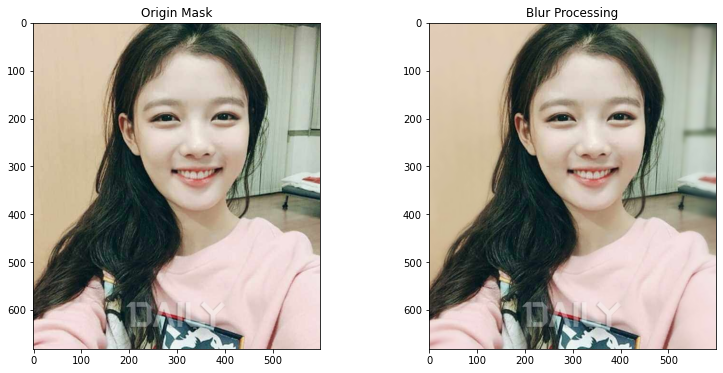

In [42]:
fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.axis('off')
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
plt.axis('off')
ax.set_title('Blur Processing')

### 2번 상대적으로 얇은 부분 해결 방안

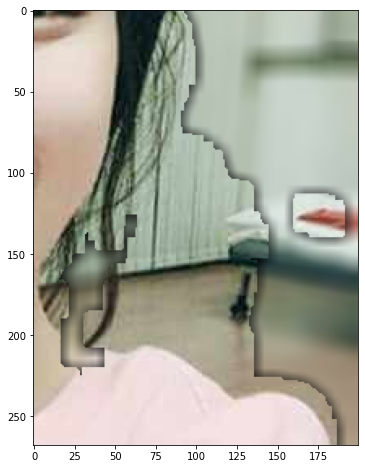

In [41]:
fig = plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img_concat[200:468, 400:600], cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

**해결방안 제시**
- 위에서 다리가 잘리는 이유는 애초에 Segmentation에서 이미지를 마스킹 할때 생기는 문제 같습니다. 모델의 성능이 좋더라도 물체가 얇다면 Mask를 씌우는 데 어려움이 있습니다. 이를 해결 하기 위해선 사진의 화질을 높이거나 컴퓨팅 성능을 높이는 방법이 있습니다. 